In [25]:
from xgboost import XGBClassifier
import xgboost
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import stats

In [26]:
def preprocess_base_feature(df_or_path):
    if isinstance(df_or_path, str):
        df_or_path = pd.read_csv(df_or_path)
    df = df_or_path
    df['mean_degree'] = (df['u_degree'] + df['u_degree']).mean()   
    X = df.drop(["Unnamed: 0"], axis=1)
    return X

def preprocess_attributes(df_or_path):

    if isinstance(df_or_path, str):
        df_or_path = pd.read_csv(df_or_path)
    df = df_or_path
    df['sex_similar'] = df['sex_u'] == df['sex_v']
    df['age_diff'] = (df['age_u'] - df['age_v']).abs()
    X = df.drop(["Unnamed: 0"], axis=1)
    return X

def load_train_data(foler_base, folder_attr, path_list, return_indexes=False, split=1):
    X_list = []
    y_list = []
    indexes_list = []
    for path in tqdm(path_list):
        X_base = preprocess_base_feature(os.path.join(foler_base, path))
        X_attr = preprocess_attributes(os.path.join(folder_attr, path))
        rich_X = X_base.merge(X_attr, on=['ego_id', 'u', 'v'])

        rich_X = rich_X.sample(frac = split)
        X = rich_X.drop(["ego_id", 'x1', 'u', 'v'], axis=1)
        
        
        names = X.columns.values.tolist()
        X = np.array(X.values).astype(np.float32)
        y = rich_X['x1']
        X_list.append(X)
        y_list.append(y)
        if return_indexes:
            indexes_list.append(rich_X[['ego_id', 'u','v']])
    X = np.concatenate(X_list, axis=0)

    X[:,0] = np.log(X[:,0] + 10)
    X[:,4] = np.log(X[:,4] + 10)
    X[:,5] = np.log(X[:,5] + 10)
    X[:,11] = np.log(X[:,11] + 10)
    X[:,12] = np.log(X[:,12] + 10)
    X[:,15] = np.log(X[:,15] + 10)
    X[:,16] = np.log(X[:,16] + 10)
    X[:,24] = np.log(X[:,24] + 10)
    
    y = np.concatenate(y_list, axis=0)
    if return_indexes:
        return X, y, names, pd.concat(indexes_list)
    return X, y, names

In [27]:
import os
CSV_DIR = "updated_train"
CSV_ATTR_DIR = "train_csv"
train_count = 30000
test_count = 3000
train_files = os.listdir(CSV_DIR)[:train_count]

train_X, train_y, train_names = load_train_data(CSV_DIR, CSV_ATTR_DIR, train_files, split=0.1)
test_X, test_y, test_names = load_train_data("updated_train", "train_csv", os.listdir(CSV_DIR)[train_count:train_count + test_count])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:07<00:00, 44.56it/s]


In [29]:
np.save("train_X.npy", train_X, allow_pickle=True, fix_imports=True)
np.save("train_y.npy", train_y, allow_pickle=True, fix_imports=True)
np.save("test_X.npy", test_X, allow_pickle=True, fix_imports=True)
np.save("test_y.npy", test_y, allow_pickle=True, fix_imports=True)
# train_X = np.load("train_X.npy")
# train_y = np.load("train_y.npy")
# test_X = np.load("test_X.npy")
# test_y = np.load("test_y.npy")

In [30]:
test_X

array([[4.5716133, 0.       , 0.       , ..., 0.       , 1.       ,
        2.3978953],
       [3.7424202, 0.       , 0.       , ..., 0.       , 1.       ,
        2.6390574],
       [4.597138 , 0.       , 0.       , ..., 0.       , 0.       ,
              nan],
       ...,
       [4.0036902, 0.       , 0.       , ..., 0.       , 0.       ,
              nan],
       [4.0036902, 0.       , 0.       , ..., 0.       , 0.       ,
              nan],
       [      nan, 0.       , 0.       , ..., 0.       , 1.       ,
        2.7725887]], dtype=float32)

## EDA

In [81]:
df = pd.DataFrame(np.concatenate([train_X, train_y[:,None]], axis=1), columns = train_names + ['x1'])[['t',
 'x1',
'x2',
 'x3',
 'density',
 'u_degree',
 'v_degree',
 'u_closeness',
 'v_closeness',
 'u_betweenness',
 'v_betweenness',
 'adamic',
 'edge_betweenness',
 'mean_degree']]

In [21]:
train_X.shape

(0, 25)



for column in train_names:
    print(column)
    x = df[['x1']].to_numpy().squeeze()
    y = df[[column]].to_numpy().squeeze()
    mask = ~np.isnan(x) & ~np.isnan(y) 
    x = x[mask]
    y = y[mask]
    print(x.shape, y.shape)
    plt.scatter(x,y)
    plt.show()
plt.figure()
plt.scatter(train_y[~np.isnan(train_y)], bins=100)

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
# #for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
# }

In [36]:
best_xgb_model = xgboost.XGBRegressor(
                 gamma=0,                
                 learning_rate=0.2,
                 max_depth=7,
                 n_estimators=100,
                 seed=42,
                 eval_metric=['rmse'],
                 #sampling_method='gradient_based',
                 objective='reg:squarederror')

best_xgb_model.fit(train_X,train_y, eval_set=[(test_X, test_y)])

[0]	validation_0-rmse:1.18226
[1]	validation_0-rmse:1.05463
[2]	validation_0-rmse:0.96356
[3]	validation_0-rmse:0.89964
[4]	validation_0-rmse:0.85575
[5]	validation_0-rmse:0.82576
[6]	validation_0-rmse:0.80522
[7]	validation_0-rmse:0.79136
[8]	validation_0-rmse:0.78192
[9]	validation_0-rmse:0.77483
[10]	validation_0-rmse:0.76963
[11]	validation_0-rmse:0.76587
[12]	validation_0-rmse:0.76346
[13]	validation_0-rmse:0.76137
[14]	validation_0-rmse:0.75963
[15]	validation_0-rmse:0.75762
[16]	validation_0-rmse:0.75683
[17]	validation_0-rmse:0.75585
[18]	validation_0-rmse:0.75510
[19]	validation_0-rmse:0.75386
[20]	validation_0-rmse:0.75292
[21]	validation_0-rmse:0.75228
[22]	validation_0-rmse:0.75176
[23]	validation_0-rmse:0.75122
[24]	validation_0-rmse:0.75089
[25]	validation_0-rmse:0.75053
[26]	validation_0-rmse:0.75024
[27]	validation_0-rmse:0.75008
[28]	validation_0-rmse:0.74968
[29]	validation_0-rmse:0.74931
[30]	validation_0-rmse:0.74919
[31]	validation_0-rmse:0.74908
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse'], feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# validation_0-rmse:0.75318 - 0.6
# validation_0-rmse:0.74838 - 0.4

In [37]:
reg = best_xgb_model.get_booster()

In [39]:
del train_X, train_y

In [40]:
from sklearn.metrics import mean_squared_error
y_pred = best_xgb_model.predict(test_X)
print(mean_squared_error(test_y, y_pred, squared=False))

0.7456722443825761


In [41]:

del test_X, test_y

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

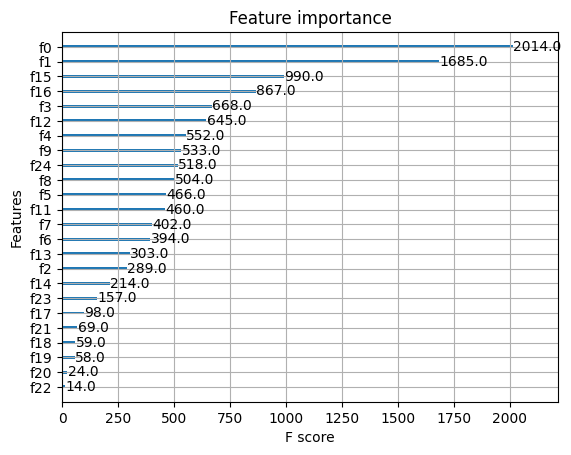

In [42]:
xgboost.plot_importance(reg)

In [43]:
import os
CSV_DIR = "updated_test"
assert len(os.listdir("updated_test")) == len(os.listdir("test_csv"))
eval_X, eval_y, names, indexes = load_train_data("updated_test", "test_csv", os.listdir("updated_test"), return_indexes=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20596/20596 [07:29<00:00, 45.85it/s]


In [44]:
y_pred = best_xgb_model.predict(eval_X)
print(mean_squared_error(eval_y[~np.isnan(eval_y)], y_pred[~np.isnan(eval_y)], squared=False))

0.7594369434876017


In [45]:
del eval_X

In [46]:
indexes['x1'] = y_pred

In [47]:
submition = pd.read_csv("/home/malchul/work/recsys/hackaton/data/submission.csv")


In [48]:
submition

,ego_id,u,v,x1
0,8,0,93,0.000000
1,8,0,143,0.000000
2,8,0,151,1.606742
3,8,1,24,0.026496
4,8,5,4,0.159857
...,...,...,...,...
810971,1709396984676,73,23,1.562170
810972,1709396984676,74,68,0.454210
810973,1709396984676,77,28,0.078504
810974,1709396984676,79,38,0.981812


In [49]:
our_submition = submition.merge(indexes, on=['ego_id', 'u', 'v'], how='left')
our_submition

,ego_id,u,v,x1_x,x1_y
0,8,0,93,0.000000,0.084316
1,8,0,143,0.000000,0.888646
2,8,0,151,1.606742,3.352593
3,8,1,24,0.026496,0.256128
4,8,5,4,0.159857,0.339661
...,...,...,...,...,...
811144,1709396984676,73,23,1.562170,0.746095
811145,1709396984676,74,68,0.454210,0.439320
811146,1709396984676,77,28,0.078504,0.764945
811147,1709396984676,79,38,0.981812,0.615605


In [50]:
our_submition = our_submition.drop('x1_x', axis=1).rename(columns={"x1_y":"x1"})
our_submition = our_submition[~our_submition[['ego_id', 'u', 'v']].duplicated(keep="first")]
our_submition

,ego_id,u,v,x1
0,8,0,93,0.084316
1,8,0,143,0.888646
2,8,0,151,3.352593
3,8,1,24,0.256128
4,8,5,4,0.339661
...,...,...,...,...
811144,1709396984676,73,23,0.746095
811145,1709396984676,74,68,0.439320
811146,1709396984676,77,28,0.764945
811147,1709396984676,79,38,0.615605


In [51]:
our_submition.to_csv("our_submition_new_sample.csv")

In [52]:
our_submition

,ego_id,u,v,x1
0,8,0,93,0.084316
1,8,0,143,0.888646
2,8,0,151,3.352593
3,8,1,24,0.256128
4,8,5,4,0.339661
...,...,...,...,...
811144,1709396984676,73,23,0.746095
811145,1709396984676,74,68,0.439320
811146,1709396984676,77,28,0.764945
811147,1709396984676,79,38,0.615605
